# Song Data Analysis and Recommendation System

## Goal

Company XYZ is a very early stage startup. They allow people to stream music from their mobile phone for free. Right now, they still only have songs from the Beatles in their music collection, but they are planning to expand soon.

They still have all their data in json files and they are interested in getting some basic info about their users as well as building a very preliminary song recommendation model in order to increase user engagement. 

Working with json files is important. If you join a very early stage start-up, they might not have a nice database and all data will be in jsons. Third party data are often stored in json files as well.

## Challenge Description

You are the fifth employee at company XYZ. The good news is that if the company becomes big, you will become very rich with the stocks. The bad news is that, at such an early stage, they data is usually very messy. All their data is stored in json files.

The company CEO asked you very specific questions:
- What are the top 3 and the bottom 3 states in terms of number of users?
- What are the top 3 and the bottom 3 states in terms of user engagement? You can choose how to mathematically define user engagement. What the CEO cares about here is in which states users are using the product a lot/very little.
- The CEO wants to send a gift to the first user woh signed up for each state. That is, the first user who signed up from California, from Oregon, etc. Can you give him a list of those users?
- Build a function that takes as an input any of the songs in the data and returns the most likely song to be listened to next. That is, if, for instance, a user is currently listening to "Eight Days a Week", which song has the highest probability of being played right after by the same user? This is going to be Version 1 of a song recommendation model.
- How would you set up a test to check whether your model works well and is improving engagement?

## Data

A single JSON file is given in the file ```song.json```.

The JSON is:

```
  "data" - all the data is here. Each row represents a song that was listened by a user.
```

**Fields**:
- **id**: Unique identifier of the row
- **user_id**: User ID who listened to a given song
- **user_state**: What state the user lives in
- **user_sign_up_date**: When the user signed up
- **song_played**: The song that was listened to
- **time_played**: At which time the user started listening to the song (local time)

## Example

```
  Let's check the first row in the JSON file:
```

| Field Name | Value | Description |
| - | - | - |
| id | GOQMMKSQQH | The unique ID of this event |
| user_id | 122 | The person who listened to that song | 
| user_state | Louisiana | State the user is based in | 
| user_sign_up_date | 2015-05-16 | Account created on May 16, 2015 |
| song_played | Hey Jude | User listened to Hey Jude | 
| time_played | 2015-06-11 21:51:35 | User listened to Hey Jude on June 11, 2016 at 9:51:35PM |

## Mount Google Drive to Colab (Optional)

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
%cd /content/drive/My Drive/Colab Notebooks/song-recommender-system

/content/drive/My Drive/Colab Notebooks/song-recommender-system


## Import Packages

In [0]:
from __future__ import (
    absolute_import,
    division, 
    print_function, 
    unicode_literals
)

In [0]:
%matplotlib inline

import os
import math
import warnings
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from pprint import pprint

warnings.simplefilter('ignore')
plt.rcParams["figure.figsize"] = (12, 5)  # Set default figure size

## Load JSON Data

JSON (JavaScript Object Notation) is an interpretable, flexible text based format to store data based on a key:value schema. We want to read the ```song.json``` file and get a feel for how our data is structured. 

In [0]:
PATH_TO_DATA_FILE = './data/song.json'

In [0]:
try:
  with open(PATH_TO_DATA_FILE, 'r') as f:
    data = json.load(f)  # convert JSON string to Python object
except FileNotFoundError:
  print('Make sure file is in ./data/song.json directory.')

## Observe JSON Schema

In [0]:
# Look at the first entry
pprint(data[0])

{'id': 'GOQMMKSQQH',
 'song_played': 'Hey Jude',
 'time_played': '2015-06-11 21:51:35',
 'user_id': 122,
 'user_sign_up_date': '2015-05-16',
 'user_state': 'Louisiana'}


We see that the JSON schema is a single dictionary with key:value pairs with six distinct keys. We do not have any nested keys, which will make wrangling our data into a pandas dataframe simple and quick.

## Data Wrangling to DataFrames

In [0]:
type(data)

list

In [0]:
type(data[0])

dict

We see that our data is simply a list of dict objects. So we can use the ```from_dict``` dataframe method to load the data. 

In [0]:
data_df = pd.DataFrame.from_dict(data)

Observe the head of the dataframe and do a sanity check that the data was successfully loaded. 

In [0]:
data_df.head()

,id,song_played,time_played,user_id,user_sign_up_date,user_state
0,GOQMMKSQQH,Hey Jude,2015-06-11 21:51:35,122,2015-05-16,Louisiana
1,HWKKBQKNWI,We Can Work It Out,2015-06-06 16:49:19,3,2015-05-01,Ohio
2,DKQSXVNJDH,Back In the U.S.S.R.,2015-06-14 02:11:29,35,2015-05-04,New Jersey
3,HLHRIDQTUW,P.s. I Love You,2015-06-08 12:26:10,126,2015-05-16,Illinois
4,SUKJCSBCYW,Sgt. Pepper's Lonely Hearts Club Band,2015-06-28 14:57:00,6,2015-05-01,New Jersey


Let's observe the data types of each column. 

In [0]:
data_df.dtypes

id                   object
song_played          object
time_played          object
user_id               int64
user_sign_up_date    object
user_state           object
dtype: object

## Feature Engineering

We see that the ```time_played``` is of type ```object```. That column can be broken up to better extract certain features of the time (e.g., month, hour, day of the week). Therefore, it would be convenient to convert this column into a datetime format and create new columns from there.

This is especially important when we want to figure out, for example, what hour of the day are most users listening to songs. 

datetime reference: https://docs.python.org/2/library/datetime.html

In [0]:
# Convert column to datetime object
data_df['time_played'] = pd.to_datetime(data_df['time_played'])

# Rename the column to datetime_played
data_df = data_df.rename(columns={'time_played': 'datetime_played'})

In [0]:
# Extract datetime features
hour = data_df['datetime_played'].dt.hour
weekday = data_df['datetime_played'].dt.weekday  # Monday is 0

In [0]:
data_df.insert(loc=3, column='hour_played', value=hour)
data_df.insert(loc=3, column='weekday_played', value=weekday)

In [0]:
data_df.head()

,id,song_played,datetime_played,weekday_played,hour_played,user_id,user_sign_up_date,user_state
0,GOQMMKSQQH,Hey Jude,2015-06-11 21:51:35,3,21,122,2015-05-16,Louisiana
1,HWKKBQKNWI,We Can Work It Out,2015-06-06 16:49:19,5,16,3,2015-05-01,Ohio
2,DKQSXVNJDH,Back In the U.S.S.R.,2015-06-14 02:11:29,6,2,35,2015-05-04,New Jersey
3,HLHRIDQTUW,P.s. I Love You,2015-06-08 12:26:10,0,12,126,2015-05-16,Illinois
4,SUKJCSBCYW,Sgt. Pepper's Lonely Hearts Club Band,2015-06-28 14:57:00,6,14,6,2015-05-01,New Jersey


In [0]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 8 columns):
id                   4000 non-null object
song_played          4000 non-null object
datetime_played      4000 non-null datetime64[ns]
weekday_played       4000 non-null int64
hour_played          4000 non-null int64
user_id              4000 non-null int64
user_sign_up_date    4000 non-null object
user_state           4000 non-null object
dtypes: datetime64[ns](1), int64(3), object(4)
memory usage: 250.1+ KB


## Exploratory Data Analysis

Now that we have the data in our desired format, we can apply exploratory data analysis (EDA) to gain some insights on user behaviors for song listening activity. 

#### Listening Activity for Hour of the Day

In [0]:
# Observe the number of song plays in a given hour of the day
data_df['hour_played'].value_counts()

14    344
15    306
18    292
12    288
17    287
13    287
16    257
11    252
19    221
10    207
20    202
9     180
21    163
22    142
8     133
23    112
7      92
6      74
5      57
4      36
3      21
1      19
2      19
0       9
Name: hour_played, dtype: int64

We can see from the above that our top 3 most active hours of song plays are at 2PM, 3PM, and 6PM. 

A count plot of this distribution is shown below.

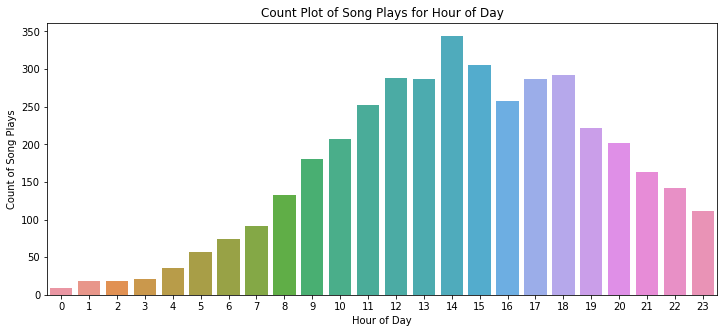

In [0]:
# Observe a histogram of the data
# sns.distplot(data_df['hour_played'], kde=False, rug=True, bins=24);
sns.countplot(data_df['hour_played'])
plt.title('Count Plot of Song Plays for Hour of Day');
plt.xlabel('Hour of Day');
plt.ylabel('Count of Song Plays');

#### Listening Activity for Day of the Week

In [0]:

data_df['weekday_played'].value_counts()

0    888
4    648
6    632
3    610
5    586
1    319
2    317
Name: weekday_played, dtype: int64

We see that that 0 (Monday) is the day that has the most song play activity. 

A count plot of this distribution is shown below.

Text(0, 0.5, 'Count of Song Plays')

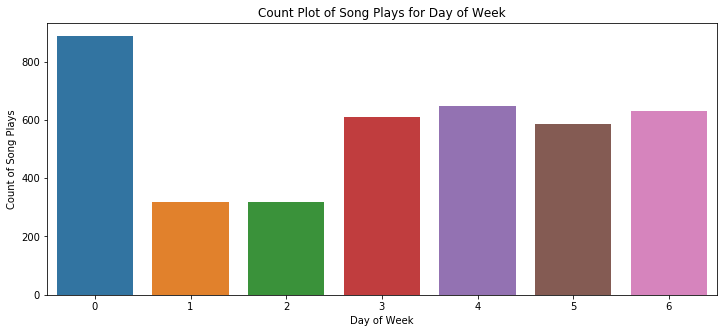

In [0]:
'''
# Dictionary to convert hour index to equivalent hour string
day_dict = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday',
            4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
  
renamed_weekday = data_df['weekday_played'].map(lambda x: day_dict[x])
'''

## TODO: Label axis according to hour strings
weekday_string = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

sns.countplot(x=data_df['weekday_played']);
plt.title('Count Plot of Song Plays for Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Count of Song Plays')

## Question: What are the top 3 and the bottom 3 states in terms of number of users?

In order to figure this out, we have to leverage the ```.groupby``` dataframe method. 

In [0]:
state_user_count = data_df.groupby(by='user_state')['user_id'].nunique().reset_index()

In [0]:
state_user_count.head()

,user_state,user_id
0,Alabama,4
1,Alaska,2
2,Arizona,1
3,Arkansas,2
4,California,21


In [0]:
# Rename user_id column to user_count
state_user_count = state_user_count.rename(columns={'user_id': 'user_count'})

In [0]:
# Sort by user counts
state_user_count = state_user_count.sort_values(by='user_count', ascending=False).reset_index()

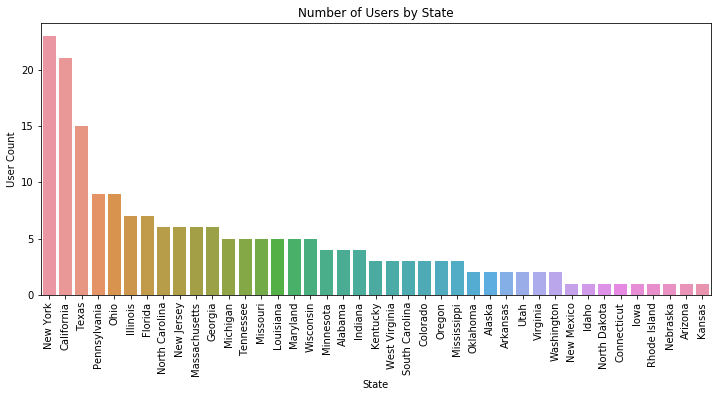

In [0]:
# Plot the distribution
plot = sns.barplot(x=state_user_count['user_state'], y=state_user_count['user_count'])
plot.set_xticklabels(labels=state_user_count['user_state'], rotation=90);
plt.title('Number of Users by State');
plt.xlabel('State');
plt.ylabel('User Count');

From the above bar plot we observe:

Top 3 states in terms of number of users: **New York, California, and Texas**

Bottom 3 states in terms of number of users: **Nebraska, Arizona, Kansas**

#### Top 3 States (Number of Users)

In [0]:
state_user_count.head(3)

,index,user_state,user_count
0,25,New York,23
1,4,California,21
2,35,Texas,15


#### Bottom 3 States (Number of Users)

In [0]:
state_user_count.tail(3)

,index,user_state,user_count
38,22,Nebraska,1
39,2,Arizona,1
40,13,Kansas,1


## Question: What are the top 3 and bottom 3 states in terms of user engagement? 

We can define user engagement in whatever feasible way. The CEO cares about which states users are using the product a lot/very little. In this case, we should focus on each state and analyze determine a feature that defines user engagement. In this case, I will cohose to analyze the following:

1. Total number of songs played by each state
2. Average number of songs played per user by each state

#### Total Number of Songs Played by Each State

In [0]:
total_plays_per_state = data_df.groupby('user_state').size().sort_values(ascending=False)
total_plays_per_state

user_state
New York          469
California        425
Texas             230
Ohio              209
Florida           180
Pennsylvania      179
North Carolina    154
Illinois          149
Georgia           135
Missouri          127
New Jersey        117
Maryland          112
Louisiana         105
Alabama           104
Tennessee         102
Wisconsin          95
Massachusetts      91
Mississippi        85
South Carolina     85
Michigan           80
Kentucky           78
Oregon             62
Alaska             58
Indiana            55
Colorado           54
Oklahoma           49
Minnesota          42
Washington         41
West Virginia      38
Utah               38
Nebraska           36
Arkansas           34
Rhode Island       27
North Dakota       26
Idaho              26
Iowa               23
Arizona            22
Virginia           17
New Mexico         17
Connecticut        16
Kansas              8
dtype: int64

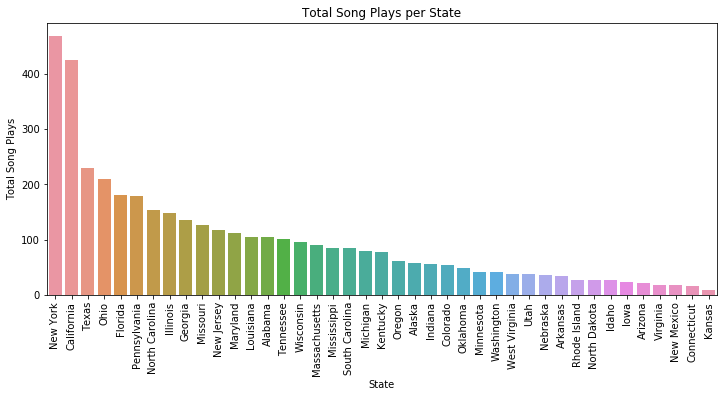

In [0]:
plot = sns.barplot(x=total_plays_per_state.index, y=total_plays_per_state.values);
plot.set_xticklabels(labels=total_plays_per_state.index, rotation=90);
plt.title('Total Song Plays per State');
plt.xlabel('State');
plt.ylabel('Total Song Plays');

We observe that New York and California make up for a large amount of the total song plays. However, this may not be as informative because we know that they consist of the most users. 

#### Average Number of Songs Played per User by Each State

Another measure of user engagement is to observe how many songs each individual users has listened to for each state. 

In [0]:
state_play_count = data_df.groupby('user_state')['id'].count().reset_index()
state_play_count = state_play_count.rename(columns={'id':'play_count'})
state_play_count.head()

,user_state,play_count
0,Alabama,104
1,Alaska,58
2,Arizona,22
3,Arkansas,34
4,California,425


In [0]:
# Merge user count and play count
state_user_play = pd.merge(left=state_play_count, right=state_user_count, on='user_state')

# Calculate the average plays per user by state and sort from highest
state_user_play['average_play'] = state_user_play['play_count']/state_user_play['user_count']
state_user_play = state_user_play.sort_values(by='average_play', ascending=False).reset_index()
state_user_play.head()

,level_0,user_state,play_count,index,user_count,average_play
0,22,Nebraska,36,22,1,36.000000
1,1,Alaska,58,1,2,29.000000
2,20,Mississippi,85,20,3,28.333333
3,33,South Carolina,85,33,3,28.333333
4,32,Rhode Island,27,32,1,27.000000


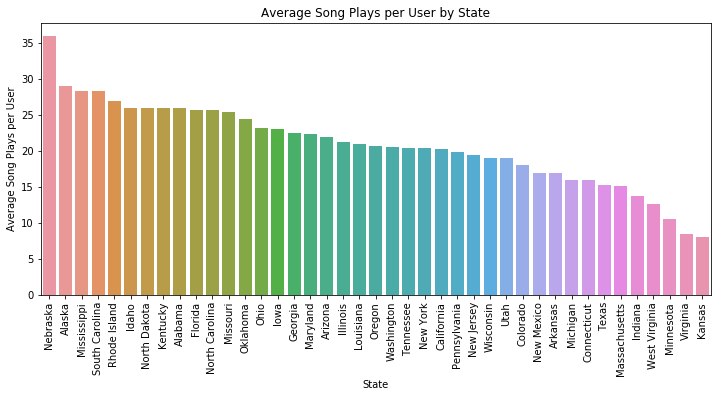

In [0]:
plot = sns.barplot(x=state_user_play['user_state'], y=state_user_play['average_play'])
plot.set_xticklabels(labels=state_user_play['user_state'], rotation=90);
plt.title('Average Song Plays per User by State');
plt.xlabel('State');
plt.ylabel('Average Song Plays per User');

#### Top 3 States (Average Song Plays per User)

In [0]:
state_user_play.head(3)

,level_0,user_state,play_count,index,user_count,average_play
0,22,Nebraska,36,22,1,36.000000
1,1,Alaska,58,1,2,29.000000
2,20,Mississippi,85,20,3,28.333333


#### Bottom 3 States (Average Song Plays per User)

In [0]:
state_user_play.tail(3)

,level_0,user_state,play_count,index,user_count,average_play
38,19,Minnesota,42,19,4,10.5
39,37,Virginia,17,37,2,8.5
40,13,Kansas,8,13,1,8.0


## Question: Who are the first users from each state that signed up?

The CEO wants to send a gift to the first users who signed up for each state. In order to do this, we have to observe the column ```user_sign_up_date``. 

In [0]:
first_users = data_df.groupby('user_state').apply(lambda x: x.sort_values(by='user_sign_up_date').iloc[0])

In [0]:
first_users.head()

,id,song_played,datetime_played,weekday_played,hour_played,user_id,user_sign_up_date,user_state
user_state,,,,,,,,
Alabama,YNQCWJKGUX,Help!,2015-06-15 16:53:10,0,16,5,2015-05-01,Alabama
Alaska,MHXECRSEEA,Revolution,2015-06-11 10:20:35,3,10,106,2015-05-12,Alaska
Arizona,NQIOZURYLR,A Day In The Life,2015-06-19 12:48:25,4,12,105,2015-05-12,Arizona
Arkansas,QWWKOJENQF,Come Together,2015-06-28 17:40:11,6,17,78,2015-05-08,Arkansas
California,VMNIDXAYBK,Come Together,2015-06-08 09:44:19,0,9,39,2015-05-04,California


We can further extract only the columns that are useful for our analysis: the ```user_id``` and ```user_sign_up_date```.

In [0]:
first_users.loc[:, ['user_id', 'user_sign_up_date']]

,user_id,user_sign_up_date
user_state,,
Alabama,5,2015-05-01
Alaska,106,2015-05-12
Arizona,105,2015-05-12
Arkansas,78,2015-05-08
California,39,2015-05-04
Colorado,173,2015-05-19
Connecticut,127,2015-05-16
Florida,41,2015-05-04
Georgia,16,2015-05-02


## Recommender System

Build a function that takes as an input any of the songs in the data and returns the most likely song to be listened next. That is, if, for instance, a user is currently listening to "Eight Days A Week", which song has the highest probability of being played right after it by the same user? This is going to be v1 of a song recommendation model.

#### User Song Play Matrix

We first start off by constructing a matrix of songs to users and the number of times a certain user played a certain song.

In [0]:
#￼# Create pivot table of song's and the count of how many times a user has listened to a song
song_user_pivot = data_df.groupby(['song_played', 'user_id'])['id'].count().unstack(fill_value=0)
song_user_pivot.head(5)

user_id,1,2,3,4,5,6,7,8,9,10,...,191,192,193,194,195,196,197,198,199,200
song_played,,,,,,,,,,,,,,,,,,,,,
A Day In The Life,0,0,1,3,0,2,0,0,0,0,...,0,0,3,3,0,2,0,0,2,0
A Hard Day's Night,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
A Saturday Club Xmas/Crimble Medley,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ANYTIME AT ALL,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Across The Universe,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [0]:
song_user_pivot.shape

(100, 196)

We observe that there are 100 distinct songs and 196 distinct users. However, it seems as if our ```user_id``` column counts from 1 to 200, but there are only 196 columns. Let's observe which ```user_id``` values are missing.

In [0]:
missing_ids = []
for i in range(1, 201, 1):
  if i in song_user_pivot.columns:
    pass
  else:
    missing_ids.append(i)

In [0]:
missing_ids

[28, 83, 139, 168]

We see that ```user_id``` 28, 83, 139, and 168 are missing. However, this is fine as it does not affect our analysis. 

### Item-Based Collaborative Filtering

#### Song Similarity Matrix

In our analysis, we will assume that users who play a certain song likely listen to songs that are similar to it. This may not hold in practice, but it is a sufficient assumption for our analysis. 

We first start by constructing a similarity matrix between songs based on our song/user song play count matrix. This is a type of **item-based collaborative filtering**. Collaborative filtering is a "memory-based" method for recommendations which uses the "wisdom of the crowd" . Item-based collaborative filtering observes only the items and the similarity between other items in the set. Based on this, typically similar items can be recommended to a user given an input item.

For this analysis we will use the cosine similarity measure for similarity between songs. 

$$sim(\vec{a}, \vec{b}) = \frac{\vec{a}\cdot\vec{b}}{|\vec{a}|*|\vec{b}|}$$




In [0]:
# Normalize the songs
song_user_norm = normalize(song_user_pivot, axis=1, norm='l2')

After normalizing each song using the L2 (Euclidean) norm, the cosine similarity between two songs is simply the dot product.

In [0]:
similarity = np.dot(song_user_norm, song_user_norm.T)  # construct the similarity matrix
similarity_df = pd.DataFrame(similarity, index=song_user_pivot.index, columns=song_user_pivot.index)
similarity_df.head()

song_played,A Day In The Life,A Hard Day's Night,A Saturday Club Xmas/Crimble Medley,ANYTIME AT ALL,Across The Universe,All My Loving,All You Need Is Love,And Your Bird Can Sing,BAD BOY,BALLAD OF JOHN AND YOKO,...,We Can Work It Out,When I'm 64,While My Guitar Gently Weeps,Wild Honey Pie,With a Little Help From My Friends,YOUR MOTHER SHOULD KNOW,Yellow Submarine,Yesterday,You Never Give Me Your Money,You're Going To Lose That Girl
song_played,,,,,,,,,,,,,,,,,,,,,
A Day In The Life,1.000000,0.235702,0.074536,0.119523,0.212132,0.355023,0.329404,0.152145,0.210819,0.172133,...,0.464938,0.030429,0.508964,0.223607,0.359092,0.037268,0.318198,0.353220,0.087841,0.0
A Hard Day's Night,0.235702,1.000000,0.000000,0.000000,0.100000,0.136931,0.111803,0.000000,0.000000,0.091287,...,0.259548,0.129099,0.210099,0.000000,0.000000,0.000000,0.050000,0.195468,0.074536,0.0
A Saturday Club Xmas/Crimble Medley,0.074536,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.109435,0.000000,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
ANYTIME AT ALL,0.119523,0.000000,0.000000,1.000000,0.000000,0.154303,0.094491,0.109109,0.000000,0.000000,...,0.116991,0.000000,0.138107,0.089087,0.183942,0.000000,0.000000,0.146845,0.000000,0.0
Across The Universe,0.212132,0.100000,0.000000,0.000000,1.000000,0.091287,0.000000,0.000000,0.000000,0.000000,...,0.138426,0.000000,0.116722,0.000000,0.000000,0.000000,0.000000,0.043437,0.000000,0.0


There are also other similarity measures (adjusted cosine similarity, pearson correlation coefficient, and jaccard similarity). 

#### Make Recommendations

We want to use the similarity matrix to find the song that is most likely to be played next, given an input song. For this, we can find the the input song's nearest neighbor and return that as the song with the highest probability of being played right after. 

In [0]:
def get_top_n_songs(similarity_matrix, input_song, n=1):
  """
  Function to return the top n neighbors to an input song based on the cosine similarity measure. 
  @param similarity_matrix the similarity matrix of songs (cosine similarity)
  @param input_song the song of interest, currently being played
  @param n the number of top-n similar songs to return
  """
  assert (n < len(similarity_matrix.columns)), 'n must be smaller than %s' % len(similarity_matrix.columns)
  
  df = similarity_matrix.loc[input_song].sort_values(ascending=False)[1:n+1].reset_index()
  df = df.rename(columns={'song_played':'Song', input_song:'Similarity'})
  return df

Let's test our function by finding the top 3 nearest neighbors to "A Day In The Life'.

In [0]:
get_top_n_songs(similarity_df, 'A Day In The Life', n=3)

,Song,Similarity
0,Come Together,0.577357
1,Revolution,0.575179
2,Get Back,0.532342


### User-Based Collaborative Filtering

Another method of collaborative filtering is **user-based collaborative filtering**. User-based collaborative filtering uses the "wisdom of the crowd" to make recommendations based on what other, similar users have.

In this case, we are just going to assume that the number of plays indicates a level of "likeness" a user has for a given song. This, of course, is not necessary the case but will be our assumptiong for analysis. Essentially, user-based collaborative filtering will recommend songs that a user has not yet listened to, but other similar users have and "liked" the song.

In [0]:
song_user_pivot.head()

user_id,1,2,3,4,5,6,7,8,9,10,...,191,192,193,194,195,196,197,198,199,200
song_played,,,,,,,,,,,,,,,,,,,,,
A Day In The Life,0,0,1,3,0,2,0,0,0,0,...,0,0,3,3,0,2,0,0,2,0
A Hard Day's Night,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
A Saturday Club Xmas/Crimble Medley,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ANYTIME AT ALL,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Across The Universe,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Pearson Correlation Matrix

A popular similarity measure in user-based collaborative filtering is the Pearson correlation. Typically this style of recommendations is better suited to movie ratings, but I am going to assume the count of plays for a song represents "likeness" of a song and will approach this problem this way, for sake of simplicity and understanding of basic collaborative filtering methodologies. 

$$ sim(a, b) = \frac{\sum_{p\in P}(r_{a,p}-\bar{r}_{a})(r_{b,p}-\bar{r}_{b})}{\sqrt{\sum_{p\in P}(r_{a,p}-\bar{r}_{a})}^2 \sqrt{\sum_{p\in P}(r_{b,p}-\bar{r}_{b})}^2} $$

where

$P$ - set of all songs played by both user a and user b  
$r_{a,p}$ - number of times user a listened to song p  
$\bar{r}_{a}$ - average number of song plays of user a  
$r_{b,p}$ - number of times user b listened to song p  
$\bar{r}_{b}$ - average number of song plays of user b

We can then use this similarity measure to make predictions:

$$pred(a,p) = \bar{r}_{a} + \frac{\sum_{b \in N}sim(a,b)*(r_{b,p}-\bar r_{b})}{\sum_{b \in N} sim(a,b)}$$

Essentially what is happening here is that we first calculate the similarity between users. This prediction function takes in account the average song plays for a given user, and uses the similarity between other users as a weight for how much a user's preference for songs will affect our prediction. Essentially the right term is a "bias" term that we use to adjust the average "likeness" of songs that a target user we are trying to recommend a song for typically has.

In [0]:
# Assign 0 play values NaN so not considered in calculation of correlation 
song_user_pivot[song_user_pivot == 0] = math.nan

In [0]:
# Compute pairwise correlation of columns
correlation_matrix = song_user_pivot.corr(method='pearson')
correlation_matrix.head()

user_id,1,2,3,4,5,6,7,8,9,10,...,191,192,193,194,195,196,197,198,199,200
user_id,,,,,,,,,,,,,,,,,,,,,
1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-0.333333,-0.069843,NaN,NaN,-0.333333,NaN,NaN,-0.333333,NaN
2,NaN,1.000000,-0.085749,0.816497,-0.500000,-0.055989,-0.5,NaN,NaN,-0.188982,...,0.943242,0.783850,0.342997,1.000000,0.813489,0.490098,NaN,0.980196,-0.471405,0.577350
3,NaN,-0.085749,1.000000,-0.062017,-0.353553,-0.420084,NaN,NaN,NaN,0.870388,...,0.103695,0.577350,0.234920,-0.106576,0.403473,-0.372104,NaN,0.853492,-0.292770,-0.612372
4,NaN,0.816497,-0.062017,1.000000,-0.375000,-0.750000,NaN,NaN,NaN,NaN,...,0.301511,NaN,0.341882,0.852803,0.583333,0.447214,NaN,0.121566,0.000000,-0.301511
5,NaN,-0.500000,-0.353553,-0.375000,1.000000,-0.271163,NaN,NaN,NaN,-0.500000,...,-0.632456,-0.577350,0.045787,0.240192,0.000000,-0.292770,NaN,-0.462910,-0.292770,0.242536


#### Make Recommendations

In [0]:
def get_top_n(correlation_matrix, user_a, n=1):
  """
  Helper function that returns the top n users similar to user a.
  @param correlation_matrix the correlation matrix between users (Pearson)
  @param user_a the user we are finding nearest neighbors for
  """
  num_not_null = correlation_matrix.loc[user_a].shape[0] - correlation_matrix.loc[user_a].isna().sum()
  assert (n < num_not_null), 'n must be smaller than %s' % num_not_null
  
  df = correlation_matrix.loc[user_a].sort_values(ascending=False)[1:n+1].reset_index()
  df = df.rename(columns={user_a: 'similarity'})
  return df
  
def get_average_plays(song_user_pivot, user):
  """
  Helper function to get a user's average song play count.
  @param song_user_pivot the user/song play count matrix
  @user_a the user we are calculating the average song plays for
  """
  return song_user_pivot.loc[:, user].mean(skipna=True)

def get_played_users(song_user_pivot, song_p):
  """
  Helper function that returns the list of users who have listened to song_p
  @param song_user_pivot the user/song play count matrix
  @song_p the song of interest
  """
  played = song_user_pivot.loc[song_p].notna()
  return [user for user in played.index if played[user] == True]
    
def predict(song_user_pivot, correlation_matrix, user_a, song_p, n=None):
  """
  Function to predict the measure of "likeness" or number of plays a user_a would
  listen to a unhead song that is being recommended.
  @param song_user_pivot the user/song play count matrix
  @param correlation_matrix the correlation matrix between users (Pearson)
  @param user_a the user we are making recommendations for
  @param song_p the song of interest 
  @param n the number of similar users to consider (n=None means consider all users)
  """
  # If n is specified, get only the top n nearest neighbors to user a to consider
  if n is not None:
    users = get_top_n(correlation_matrix, user_a, n).loc[:, 'user_id'].values
  # Else consider all users who have a correlation value that isn't NaN
  else:
    num_not_null = correlation_matrix.loc[user_a].shape[0] - correlation_matrix.loc[user_a].isna().sum()
    users = get_top_n(correlation_matrix, user_a, num_not_null-1).loc[:, 'user_id'].values
  
  # Accumulation variables for calculating the bias
  numer_accum = 0.0
  denom_accum = 0.0
  
  # Get similar users who have listened to song_p
  played_users = get_played_users(song_user_pivot, song_p)
  played_similar_users = [user for user in played_users if user in users]

  # Calculate the bias
  for user_b in played_similar_users:
    similarity = correlation_matrix.loc[user_a, user_b]
    rbp = song_user_pivot.loc[song_p, user_b]
    rb_avg = get_average_plays(song_user_pivot, user_b)
    numer_accum += similarity * (rbp-rb_avg)
    denom_accum += similarity
  if denom_accum == 0.0:
    bias = 0.0
  else:
    bias = numer_accum / denom_accum

  ra_avg = get_average_plays(song_user_pivot, user_a)
  pred = ra_avg + bias
  return pred

def recommend(song_user_pivot, user_a, n=None):
  """
  Function to make song recommendations for user_a.
  @param song_user_pivot the user/song play count matrix
  @param user_a the user we are making recommendations for
  @param n the number of similar users to consider (n=None means consider all users)
  """
  # Assign 0 play values NaN so not considered in calculation of correlation 
  song_user_pivot[song_user_pivot == 0] = math.nan

  # Compute pairwise correlation of columns
  correlation_matrix = song_user_pivot.corr(method='pearson')
  
  user_series = song_user_pivot.loc[:, user_a]
  user_unheard = user_series[user_series.isna()]

  # Calculate the predictions for each unheard song
  for song in user_unheard.index:
    user_unheard[song] = predict(song_user_pivot, correlation_matrix, user_a, song, n)
    
  recommendations = pd.DataFrame(user_unheard).rename(columns={user_a: 'predictions'})
  return recommendations.sort_values(by='predictions', ascending=False)

In [0]:
recommend(song_user_pivot, 100).head(10)

,predictions
song_played,
Back In the U.S.S.R.,1.453084
Let It Be,1.406160
Hello Goodbye,1.285505
Something,1.262192
IT WON'T BE LONG,1.135483
Hey Jude,1.135294
We Can Work It Out,1.132171
Lucy In The Sky With Diamonds,1.131637
Can't Buy Me Love,1.122198
